In [1]:
import pandas as pd
import numpy as np
from CrossValidation import *

from utilities import *
from features import *

In [2]:
df_ohlcv = read_CSV('data/alt_bars/XRPUSDT_dollar.csv', index ='Time')
df_ohlcv['barID'] = df_ohlcv.reset_index().index.values
df_ohlcv = df_ohlcv.reset_index().drop_duplicates(subset='Time', keep='first').set_index('Time')
if False: # Cut off
    df_ohlcv = df_ohlcv.loc[pd.to_datetime("2021-01-01"):]
    # df_ohlcv.Close.plot(); plt.show()

# Data Prep
btc = read_CSV('data/alt_bars/BTCUSDT_dollar.csv', index = 'Time')
btc['barID'] = btc.reset_index().index.values
btc = btc.reset_index().drop_duplicates(subset='Time', keep='first').set_index('Time')

if False:
    btc = btc.loc[pd.to_datetime("2021-01-01"):]
    # btc.Close.plot(); plt.show()

In [3]:
def getFeatUtility (feat, ret, df_ohlcv, hpBar, numDays, crossing, mid = None, robust = False, visual = False, n_quantiles=200):
    '''This outputs the utility of a feature. Utility is defined as annual total return times annual sharpe'''
    '''Num Days required for annualization'''
    # Iterate through thresholds
    quantiles = feat.quantile(np.arange(0.00, 1.0001, 1/n_quantiles))
    if mid is None:
        mid = feat.quantile(0.50)

    tot_rets, sharpes, utilities, freq = pd.Series(index = quantiles, dtype=float), pd.Series(index= quantiles, dtype=float), pd.Series(index= quantiles, dtype=float), pd.Series(index= quantiles, dtype=float)

    for thres in quantiles:

        # Get Signals
        if crossing == 'outward':
            if thres >= mid:
                events = (feat >= thres) & (feat.shift() < thres)
            else:
                events = (feat <= thres) & (feat.shift() > thres)
        elif crossing == 'upward':
            events = (feat >= thres) & (feat.shift() < thres)
        elif crossing == 'downward':
            events = (feat <= thres) & (feat.shift() > thres)
        else:
            raise ValueError("Invalide crossing method")
        
        events = pd.DataFrame(index = events.index[events.values])
        events['barID'] = df_ohlcv.barID[events.index]
        events = removeTimeOverlap(events, hpBars = hpBar, dBars = 1)

        # Get Returns
        feat_ret = ret[events.index]
        daily_ret = feat_ret.resample('1D').sum()
        daily_ret = daily_ret[daily_ret!=0].dropna()

        # Make Robust
        if robust:
            monthly_sums = daily_ret.resample('M').sum() # Step 1: Group by month and sum
            best_month = monthly_sums.idxmax() # Step 2: Identify the best and worst month
            daily_ret = daily_ret[(daily_ret.index.month != best_month.month) | (daily_ret.index.year != best_month.year)] # Step 3: Filter out the best from the original Series        

        # Compute Metrics
        if len(daily_ret) > 10:
            tot_ret = daily_ret.sum()/numDays*365 # annualized
            std = np.sqrt((daily_ret**2).sum()) * np.sqrt(365/numDays)
            sharpe = tot_ret / std
            utility = tot_ret*max(0,min(6,sharpe))
        else:
            continue

        # Save
        tot_rets[thres]= tot_ret
        sharpes[thres] = sharpe
        utilities[thres] = utility

    if visual:
        utilities.plot(label='utility');plt.legend();plt.show()
        sharpes.plot(label='sharpe'); plt.axhline(y=0); plt.axvline(x=mid); plt.legend();plt.show()
        tot_rets.plot(label='annual return'); plt.axhline(y=0); plt.axvline(x=mid); plt.legend();plt.show()
        

    return utilities

### Feature Search

In [5]:
# CV 1
trainStart, trainEnd = pd.to_datetime("2022-01-01"), pd.to_datetime("2023-07-30")
testStart, testEnd = pd.to_datetime("2023-08-01"), pd.to_datetime("2024-02-01")

# CV 2
# trainStart, trainEnd = pd.to_datetime("2023-01-01"), pd.to_datetime("2024-02-01")
# testStart, testEnd = pd.to_datetime("2022-06-01"), pd.to_datetime("2022-12-31")

trainDays = (trainEnd - trainStart).days
testDays = (testEnd - testStart).days

In [26]:
# Paramameter Grid
is_test = False
lookback = 100
scales = [1, 5, 10, 15, 20]
hpBars = [50, 100, 200, 300, 600]
side= 'long'
commission = 0.0005

In [28]:
# Feature Grid

all_features = [
    # [featureName, featureFunction, additionalParams]
    ['blgr',blgr, {'close': df_ohlcv.Close,'num_cpu':2}],
    ['roc',getroc, {'close': df_ohlcv.Close,'num_cpu':2}],
    ['trend',getTrend, {'close': df_ohlcv.Close,'use_log':True,'num_cpu':2}],
    ['sr',getSR, {'df_ohlcv':df_ohlcv, 'n_bins':2, 'nFrac':50, 'num_cpu':1}],
    ['ar1', getAR1, {'close': df_ohlcv.Close, 'diff': True, 'use_log':True,'num_cpu':2}],
    ['aLambda', amihudsLambda, {'df_volbar': df_ohlcv,'num_cpu':2}],
    ['kLambda', kylesLambda, {'df_volbar': df_ohlcv,'num_cpu':2}],
    ['hLambda', hasbroucksLambda, {'df_volbar': df_ohlcv,'num_cpu':2}],
    ['netDollar', scaled_rolling, {'series': df_ohlcv.Dollar_buy, 'grouping':'sum', 'rolling':'sum', 'num_cpu':2}],
    
    # takes too long
    # ['adfc', getADF, {'close': df_ohlcv.Close,'grouping': 'last', 'constant':'c', 'grouping':'last', 'use_log':True, 'lags': 3}],
]

In [29]:
# Prepare Y
Y = pd.DataFrame()
for hpBar in hpBars:
    if side == 'long':
        ret = df_ohlcv.Close.shift(-hpBar)/df_ohlcv.Close -1 - 2*commission
    else:
        ret = 1 - df_ohlcv.Close.shift(-hpBar)/df_ohlcv.Close - 2*commission
    ret = np.log(1+ret)
    Y[hpBar] = ret

In [30]:
out_mean = pd.Series(dtype=float)
out_max = pd.Series(dtype=float)
out_dict = {}
for name, func, additionalParams in all_features:

    # Prepare X
    X = pd.DataFrame()
    for scale in scales:
        # Generating tEvent for the current scale
        tEvent = df_ohlcv[trainStart:trainEnd].index
        
        # If there are additional parameters, unpack them when calling the function
        if additionalParams:
            X[scale] = mpPandasObj(func, tEvent, lookback=lookback, scale=scale, **additionalParams)
        else:
            X[scale] = mpPandasObj(func, tEvent, lookback=lookback, scale=scale)


    # Run Feature Analysis
    aaz = pd.DataFrame(index = X.columns, columns = Y.columns, dtype = float) # Area above zero
    maxU = pd.DataFrame(index = X.columns, columns = Y.columns, dtype = float) # Max utility
    for xcol in X:
        feat = X[xcol]
        for ycol in Y:
            ret = Y[ycol]
            feat_train = feat[trainStart:trainEnd]

            utilities = getFeatUtility(feat_train, ret, df_ohlcv, hpBar = ycol, numDays = trainDays, mid=None)
            aaz_utility = utilities[utilities>0].sum() 
            max_utility = np.nanmax(utilities)
            
            aaz.loc[xcol,ycol]= aaz_utility
            maxU.loc[xcol,ycol]= max_utility
    
    out_mean[name] = aaz.mean().mean()
    out_max[name] = aaz.max().max()
    out_dict[name] = aaz
    print(name,'done')

100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


blgr done


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


roc done


100%|██████████| 2/2 [00:17<00:00,  8.76s/it]


trend done
sr done


100%|██████████| 2/2 [01:08<00:00, 34.11s/it]


ar1 done


100%|██████████| 2/2 [00:12<00:00,  6.49s/it]


aLambda done


100%|██████████| 2/2 [00:13<00:00,  6.67s/it]


kLambda done


100%|██████████| 2/2 [00:13<00:00,  6.56s/it]


hLambda done


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


netDollar done


In [31]:
out_max

blgr         14.514393
roc          16.501808
trend        14.236465
sr            3.127867
ar1          16.930082
aLambda      11.388348
kLambda      11.688060
hLambda      10.445225
netDollar    17.864504
dtype: float64

In [32]:
out_mean

blgr         4.912116
roc          4.429390
trend        4.232423
sr           1.166248
ar1          4.072776
aLambda      2.431401
kLambda      2.929999
hLambda      2.453300
netDollar    5.195838
dtype: float64

In [37]:
out_dict['netDollar']

,50,100,200,300,600
1,0.627011,1.008996,1.423055,1.308689,5.552409
5,1.656191,2.980491,12.445144,17.466922,17.864504
10,2.862352,8.794763,6.333960,6.101350,1.361295
15,0.816679,1.887089,3.618521,5.147037,3.373145
20,2.884846,5.223015,6.144904,7.768971,5.244600


In [38]:
out_dict['blgr']

,50,100,200,300,600
1,0.226019,0.063983,0.404117,0.300592,0.153582
5,1.112229,1.278589,0.300604,0.216335,2.129678
10,1.509059,4.447139,14.514393,11.429319,12.312695
15,4.399455,8.328964,12.763836,7.179552,3.204412
20,4.009005,6.891849,11.723967,7.950350,5.953184


### Feature Optimization

Zoom in on one feature and run a hyperparameter grid search

In [100]:
# CV 1
trainStart, trainEnd = pd.to_datetime("2022-01-01"), pd.to_datetime("2023-07-30")
testStart, testEnd = pd.to_datetime("2023-08-01"), pd.to_datetime("2024-02-01")

# CV 2
# trainStart, trainEnd = pd.to_datetime("2023-01-01"), pd.to_datetime("2024-02-01")
# testStart, testEnd = pd.to_datetime("2022-06-01"), pd.to_datetime("2022-12-31")

trainDays = (trainEnd - trainStart).days
testDays = (testEnd - testStart).days

In [159]:
# Param Grid
lookback = 100
scales = [10]
hpBars = [200]
# scales = [4, 8, 12, 16, 20]
# hpBars = [50, 100, 150, 200, 300]
side= 'long'
commission = 0.00

In [160]:
# Prep Features
X = pd.DataFrame()
for scale in scales:
    tEvent = df_ohlcv.index[lookback*scale:]
    X[scale] = mpPandasObj(blgr, tEvent, num_cpu = 2, close = df_ohlcv.Close, lookback = lookback, scale = scale)
    # X[scale] = mpPandasObj(scaled_rolling, tEvent, num_cpu = 2, series = df_ohlcv.Dollar_buy, lookback = lookback, scale = scale, grouping='sum', rolling='sum')

# Prep Returns
Y = pd.DataFrame()
for hpBar in hpBars:
    if side == 'long':
        ret = df_ohlcv.Close.shift(-hpBar)/df_ohlcv.Close -1 - 2*commission
    else:
        ret = 1 - df_ohlcv.Close.shift(-hpBar)/df_ohlcv.Close - 2*commission
    ret = np.log(1+ret)
    Y[hpBar] = ret

100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


In [ ]:
# Run Feature Analysis
aaz = pd.DataFrame(index = X.columns, columns = Y.columns, dtype = float) # Area above zero
maxU = pd.DataFrame(index = X.columns, columns = Y.columns, dtype = float) # Max utility
for xcol in X:
    feat = X[xcol]
    for ycol in Y:
        ret = Y[ycol]
        feat_train = feat[trainStart:trainEnd]

        utilities = getFeatUtility(feat_train, ret, df_ohlcv, hpBar = ycol, numDays = trainDays, mid=None)
        aaz_utility = utilities[utilities>0].sum() 
        max_utility = np.nanmax(utilities)
        
        aaz.loc[xcol,ycol]= aaz_utility
        maxU.loc[xcol,ycol]= max_utility

In [113]:
aaz

,50,100,150,200,300
4,0.000000,0.460318,0.001105,0.097378,0.443449
8,0.168110,0.305596,0.374550,1.828977,2.283808
12,0.258758,0.718198,0.674291,0.291343,1.639323
16,0.649917,0.729554,1.128502,0.899407,0.842692
20,0.496844,0.692511,2.047350,1.540008,2.422661


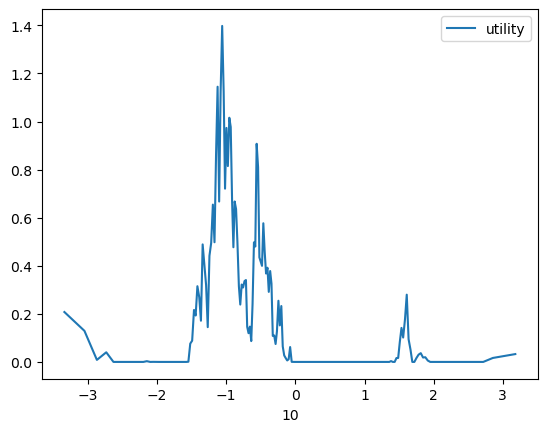

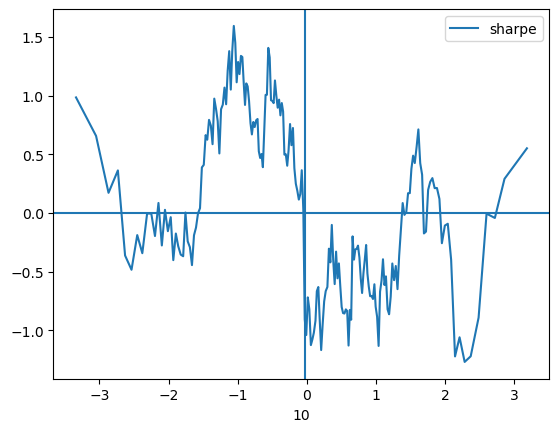

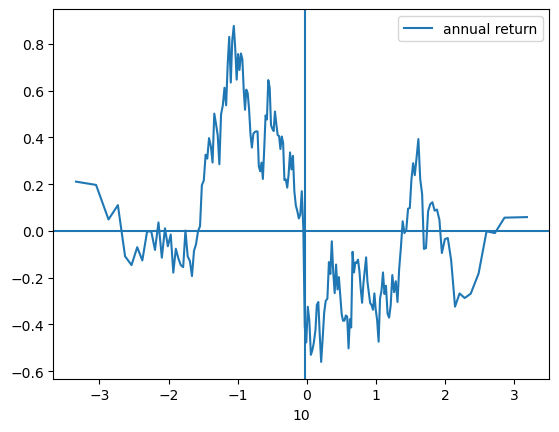

10
-6.630586         NaN
-3.338710    0.207542
-3.048951    0.129241
-2.868755    0.008422
-2.733500    0.040028
               ...   
 2.596049   -0.000000
 2.716173   -0.000000
 2.855490    0.016508
 3.179679    0.032599
 6.020275         NaN
Length: 201, dtype: float64

In [164]:
#long
getFeatUtility (X[10][trainStart:trainEnd], Y[200], df_ohlcv, hpBar = 200, numDays =  trainDays, mid = None, robust = False, visual = True)
# getUtility (X[10][testStart:testEnd], Y[200], df_ohlcv, hpBar = 200, numDays =  trainDays, mid = None, robust = False, visual = True)

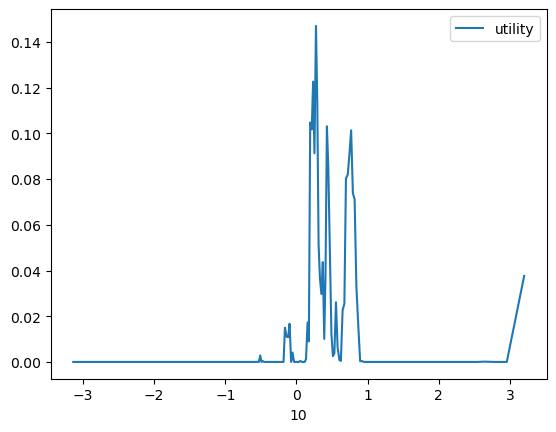

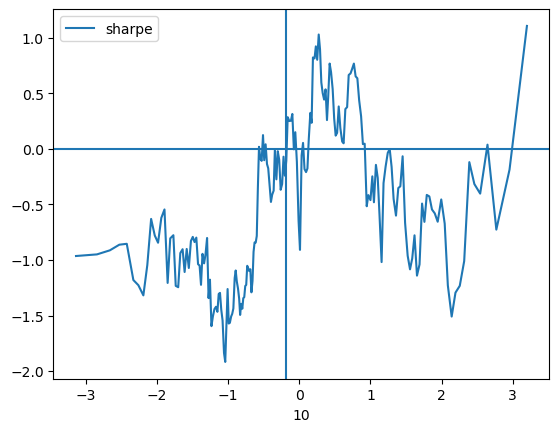

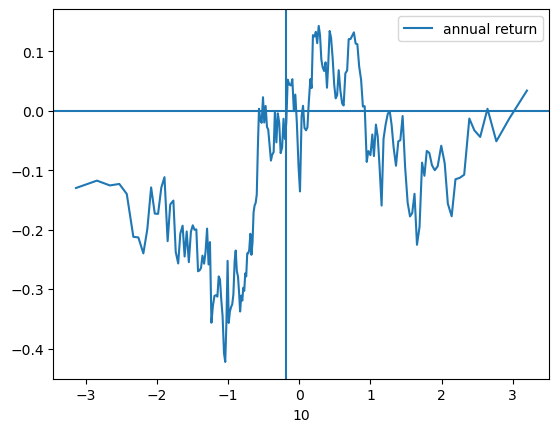

10
-7.932148         NaN
-3.785517         NaN
-3.135100   -0.000000
-2.841362   -0.000000
-2.659778   -0.000000
               ...   
 2.768512   -0.000000
 2.953851   -0.000000
 3.198140    0.037636
 3.539336         NaN
 5.149498         NaN
Length: 201, dtype: float64

In [153]:
#short
# getUtility (X[10][trainStart:trainEnd], Y[100], df_ohlcv, hpBar = 100, numDays =  trainDays, mid = None, robust = False, visual = True)
getFeatUtility (X[10][testStart:testEnd], Y[100], df_ohlcv, hpBar = 100, numDays =  trainDays, mid = None, robust = False, visual = True)

### Visualize Returns

In [138]:

# feat = X[10][trainStart:trainEnd]
feat = X[10][trainStart:]
ret = Y[200]
thres = -1
mid = 0

if thres >= mid:
    events = (feat >= thres) & (feat.shift() < thres)
else:
    events = (feat <= thres) & (feat.shift() > thres)
events = pd.DataFrame(index = events.index[events.values])
events['barID'] = df_ohlcv.barID[events.index]
events = removeTimeOverlap(events, hpBars = hpBar, dBars = 1)

# Get Returns
feat_ret = ret[events.index]
daily_ret = feat_ret.resample('1D').sum()
daily_ret = daily_ret[daily_ret!=0].dropna()

In [139]:
len(feat_ret)

341

<Axes: xlabel='Time'>

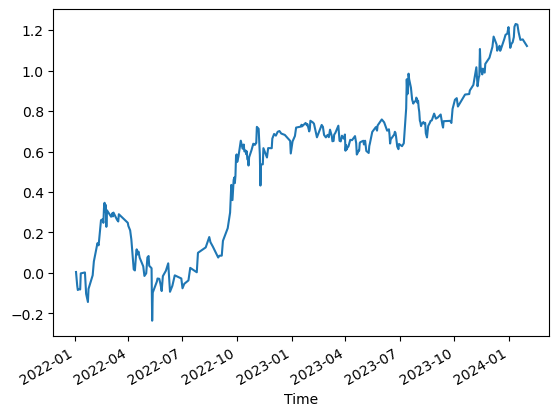

In [140]:
daily_ret.cumsum().plot()